In [1]:
# Can you predict the followers and approval rating of a senator based on tweets?

from math import ceil
import csv
import json
import os
import requests
import tweepy
import textblob
import pandas as pd
import numpy as np
from scipy import stats
import re
from textblob import TextBlob
from dateutil import rrule
from dateutil.rrule import rrule, WEEKLY
import datetime
from datetime import datetime
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import matplotlib.pyplot as plt
import seaborn
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

In [134]:
# Paths to Credit Json Locations
DEFAULT_TWITTER_CREDS_PATH = 'path/file.json'
DEFAULT_PLOTLY_CREDS_PATH = 'path/file.json'

In [135]:
fn = os.path.expanduser(DEFAULT_PLOTLY_CREDS_PATH)  # get the full path in case the ~ is used
creds = json.load(open(fn))
    # Get authentication token
plotly.tools.set_credentials_file(username=creds['username'], api_key=creds['api_key'])

In [4]:
url = 'https://morningconsult.com/2017/10/31/americas-most-and-least-popular-senators-october-2017/'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
response = requests.get(url)
page = urlopen(req)
soup = BeautifulSoup(page, "lxml")

In [5]:
new_table = pd.DataFrame(columns=range(0,6), index=range(0,100))
table = soup.find_all('table')[0]
row_marker = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        new_table.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    if len(columns) > 0:
        row_marker += 1      
new_table.columns = ['State','Name', 'Approve','Dissaprove','Dont Know', 'Error Margin']
new_table['Approve'] = new_table['Approve'].map(lambda x: x.rstrip('%'))
new_table['Dissaprove'] = new_table['Dissaprove'].map(lambda x: x.rstrip('%'))
new_table['Dont Know'] = new_table['Dont Know'].map(lambda x: x.rstrip('%'))
new_table['Error Margin'] = new_table['Error Margin'].map(lambda x: x.rstrip('%'))
new_table['Approve'] = new_table['Approve'].map(lambda x: int(float(x)))
new_table['Dissaprove'] = new_table['Dissaprove'].map(lambda x: int(float(x)))
new_table['Dont Know'] = new_table['Dont Know'].map(lambda x: int(float(x)))
new_table['Error Margin'] = new_table['Error Margin'].map(lambda x: int(float(x)))
new_table_NameFilter = pd.DataFrame(new_table['Name'])
new_table_NameFilter.columns = ['Name']
ApprovalRating = new_table
ApprovalRating

,State,Name,Approve,Dissaprove,Dont Know,Error Margin
0,Alabama,Richard Shelby,53,27,20,1
1,Alabama,Luther Strange,44,34,23,1
2,Alaska,Lisa Murkowski,49,38,13,5
3,Alaska,Dan Sullivan,49,32,18,5
4,Arizona,John McCain,46,44,10,1
5,Arizona,Jeff Flake,33,48,20,1
6,Arkansas,Tom Cotton,55,27,18,2
7,Arkansas,John Boozman,52,23,25,2
8,California,Dianne Feinstein,47,33,20,1
9,California,Kamala Harris,46,26,28,1


In [7]:
def get_api(credsfile = DEFAULT_TWITTER_CREDS_PATH):
    fn = os.path.expanduser(credsfile)  # get the full path in case the ~ is used
    c = json.load(open(fn))
    # Get authentication token
    auth = tweepy.OAuthHandler(consumer_key = c['consumer_key'],
                               consumer_secret = c['consumer_secret'])
    auth.set_access_token(c['access_token'], c['access_token_secret'])
    # create an API handler
    return tweepy.API(auth)

In [8]:
BATCH_SIZE = 100
def get_profiles_from_screen_names(snames):
    api = get_api()
    profiles = []
    for i in range(ceil(len(snames) / BATCH_SIZE)):
        s = i * BATCH_SIZE
        bnames = snames[s:(s + BATCH_SIZE)]
        for user in api.lookup_users(screen_names = bnames):
            profiles.append(user._json)
    return profiles

In [9]:
csvurl = 'http://unitedstates.sunlightfoundation.com/legislators/legislators.csv'
rows = csv.DictReader(requests.get(csvurl).text.splitlines())
legislators = [r for r in rows if r['twitter_id'] and r['in_office'] == '1']
twitter_profiles = get_profiles_from_screen_names([x['twitter_id'] for x in legislators])
for lx in legislators:
    ta = [t for t in twitter_profiles if lx['twitter_id'].lower() == t['screen_name'].lower()]
    lx['twitter_profile'] = ta[0] if ta else None

In [10]:
type(legislators)

list

In [11]:
Legislators=pd.DataFrame(legislators)

In [12]:
Legislators['Name'] = Legislators['firstname'] + ' ' + Legislators['lastname']

In [13]:
Legislators = Legislators.merge(new_table_NameFilter, how='inner', left_on='Name', right_on='Name')
Legislators

,title,firstname,middlename,lastname,name_suffix,nickname,party,state,district,in_office,...,twitter_id,congresspedia_url,youtube_url,facebook_id,official_rss,senate_class,birthdate,oc_email,twitter_profile,Name
0,Sen,Lamar,,Alexander,,,R,TN,Senior Seat,1,...,SenAlexander,http://www.opencongress.org/wiki/Lamar_Alexander,http://youtube.com/lamaralexander,senatorlamaralexander,,II,1940-07-03,Sen.Alexander@opencongress.org,"{'id': 76649729, 'id_str': '76649729', 'name':...",Lamar Alexander
1,Sen,Roy,,Blunt,,,R,MO,Junior Seat,1,...,RoyBlunt,http://www.opencongress.org/wiki/Roy_Blunt,http://youtube.com/SenatorBlunt,SenatorBlunt,,III,1950-01-10,Sen.Blunt@opencongress.org,"{'id': 21269970, 'id_str': '21269970', 'name':...",Roy Blunt
2,Sen,Sherrod,,Brown,,,D,OH,Senior Seat,1,...,SenSherrodBrown,http://www.opencongress.org/wiki/Sherrod_Brown,http://youtube.com/SherrodBrownOhio,SenatorSherrodBrown,,I,1952-11-09,Sen.Brown@opencongress.org,"{'id': 43910797, 'id_str': '43910797', 'name':...",Sherrod Brown
3,Sen,Richard,M.,Burr,,,R,NC,Senior Seat,1,...,SenatorBurr,http://www.opencongress.org/wiki/Richard_Burr,http://youtube.com/SenatorRichardBurr,SenatorRichardBurr,,III,1955-11-30,Sen.Burr@opencongress.org,"{'id': 21157904, 'id_str': '21157904', 'name':...",Richard Burr
4,Sen,Tammy,,Baldwin,,,D,WI,Junior Seat,1,...,SenatorBaldwin,http://www.opencongress.org/wiki/Tammy_Baldwin,http://youtube.com/witammybaldwin,senatortammybaldwin,,I,1962-02-11,Sen.Baldwin@opencongress.org,"{'id': 1074518754, 'id_str': '1074518754', 'na...",Tammy Baldwin
5,Sen,John,,Boozman,,,R,AR,Senior Seat,1,...,JohnBoozman,http://www.opencongress.org/wiki/John_Boozman,http://youtube.com/BoozmanPressOffice,JohnBoozman,,III,1950-12-10,Sen.Boozman@opencongress.org,"{'id': 5558312, 'id_str': '5558312', 'name': '...",John Boozman
6,Sen,John,A.,Barrasso,,,R,WY,Junior Seat,1,...,SenJohnBarrasso,http://www.opencongress.org/wiki/John_Barrasso,http://youtube.com/barrassowyo,johnbarrasso,,I,1952-07-21,Sen.Barrasso@opencongress.org,"{'id': 202206694, 'id_str': '202206694', 'name...",John Barrasso
7,Sen,Michael,F.,Bennet,,,D,CO,Senior Seat,1,...,SenBennetCo,http://www.opencongress.org/wiki/Michael_Bennet,http://youtube.com/SenatorBennet,senbennetco,,III,1964-11-28,Sen.Bennet@opencongress.org,"{'id': 224285242, 'id_str': '224285242', 'name...",Michael Bennet
8,Sen,Richard,,Blumenthal,,,D,CT,Senior Seat,1,...,SenBlumenthal,http://www.opencongress.org/wiki/Richard_Blume...,http://youtube.com/SenatorBlumenthal,SenBlumenthal,,III,1946-02-13,Sen.Blumenthal@opencongress.org,"{'id': 278124059, 'id_str': '278124059', 'name...",Richard Blumenthal
9,Sen,Cory,Anthony,Booker,,,D,NJ,Junior Seat,1,...,SenBooker,,http://youtube.com/SenCoryBooker,,,II,1969-04-27,Sen.Booker@opencongress.org,"{'id': 2167097881, 'id_str': '2167097881', 'na...",Cory Booker


In [14]:
Legislators_twitter_id =Legislators['twitter_id'].tolist()

In [15]:
Profiles = pd.DataFrame(twitter_profiles)
Followers = Profiles[['screen_name','followers_count']]

In [16]:
Legislator_Name = Legislators[['twitter_id', 'Name']]

In [75]:
Legislator_Name

,twitter_id,Name
0,SenAlexander,Lamar Alexander
1,RoyBlunt,Roy Blunt
2,SenSherrodBrown,Sherrod Brown
3,SenatorBurr,Richard Burr
4,SenatorBaldwin,Tammy Baldwin
5,JohnBoozman,John Boozman
6,SenJohnBarrasso,John Barrasso
7,SenBennetCo,Michael Bennet
8,SenBlumenthal,Richard Blumenthal
9,SenBooker,Cory Booker


In [17]:
len(Legislators_twitter_id)

81

In [18]:
Legislators_twitter_id[0:81]
# 'SenToddYoung'

['SenAlexander',
 'RoyBlunt',
 'SenSherrodBrown',
 'SenatorBurr',
 'SenatorBaldwin',
 'JohnBoozman',
 'SenJohnBarrasso',
 'SenBennetCo',
 'SenBlumenthal',
 'SenBooker',
 'SenatorCantwell',
 'SenatorCarper',
 'SenThadCochran',
 'MikeCrapo',
 'SenatorCollins',
 'JohnCornyn',
 'SenBobCasey',
 'SenBobCorker',
 'SenCoonsOffice',
 'SenTomCotton',
 'SenTedCruz',
 'sencortezmasto',
 'SenDonnelly',
 'SteveDaines',
 'SenDuckworth',
 'SenJoniErnst',
 'SenFeinstein',
 'JeffFlake',
 'SenatorFischer',
 'GrahamBlog',
 'SenGillibrand',
 'SenCoryGardner',
 'SenOrrinHatch',
 'SenDeanHeller',
 'MazieHirono',
 'MartinHeinrich',
 'SenJohnHoeven',
 'SenatorHeitkamp',
 'SenKamalaHarris',
 'InhofePress',
 'SenatorIsakson',
 'SenRonJohnson',
 'SenAngusKing',
 'SenJohnKennedy',
 'SenatorLeahy',
 'SenatorLankford',
 'SenMikeLee',
 'SenJohnMcCain',
 'McConnellPress',
 'JerryMoran',
 'PattyMurray',
 'LisaMurkowski',
 'McCaskillOffice',
 'SenJeffMerkley',
 'Sen_JoeManchin',
 'SenBillNelson',
 'SenGaryPeters',
 'sen

In [19]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [20]:
def get_tweet_sentiment(tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

In [21]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #authorize twitter, initialize tweepy
        api = get_api()
    
    #initialize a list to hold all the tweepy Tweets
        alltweets = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
        try:
            new_tweets = api.user_timeline(screen_name = screen_name, count=200)
            alltweets.extend(new_tweets) 
    #save most recent tweets
        except tweepy.TweepError:
            print("Failed to run the command on that user, Skipping...")  
    # The following Code is to attempt to grab all tweets, don't use for large batches!
    #save the id of the oldest tweet less one
        # oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
        # while len(new_tweets) > 0:
       
        #all subsiquent requests use the max_id param to prevent duplicates
          #  new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

        #save most recent tweets
          #  alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
           # oldest = alltweets[-1].id - 1
    
        
    #transform the tweepy tweets into a 2D array that will populate the csv	
        
    # outtweets = [[screen_name, tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
        outtweets = [[screen_name, get_tweet_sentiment(tweet.text)] for tweet in alltweets]
        return outtweets
        
pass

In [22]:
def get_all_tweets_References(screen_name):
        api = get_api()
        alltweets = []
        try:
            new_tweets = api.user_timeline(screen_name = screen_name, count=200)
            alltweets.extend(new_tweets) 
        except tweepy.TweepError:
            print("Failed to run the command on that user, Skipping...")  
        alltweets = [tweet.text for tweet in alltweets]
        outtweets = [[screen_name, get_tweet_sentiment(x), e] for e in Legislators_twitter_id for x in alltweets if e in x]
        return outtweets
        
pass

In [23]:
def get_all_tweets_dates(screen_name):
        api = get_api()
        alltweets = []
        try:
            new_tweets = api.user_timeline(screen_name = screen_name, count=200)
            alltweets.extend(new_tweets) 
        except tweepy.TweepError:
            print("Failed to run the command on that user, Skipping...")  
        outtweets = [[screen_name, tweet.created_at] for tweet in alltweets]
        return outtweets
        
pass

In [104]:
df_GetsMentioned = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_GetsMentioned = df_GetsMentioned.append(pd.DataFrame(get_all_tweets_References(screen_name)))
df_GetsMentioned.columns = ['Tweeter','Sentiment', 'Reference']
df_GetsMentioned = df_GetsMentioned.loc[df_GetsMentioned['Tweeter'] != df_GetsMentioned['Reference']]
df_GetsMentioned = df_GetsMentioned.drop(['Sentiment'], axis=1)
df_GetsMentioned = df_GetsMentioned.pivot_table(index=['Reference'], aggfunc=(len))
df_GetsMentioned = pd.DataFrame(df_GetsMentioned.to_records()).rename(columns={'Tweeter': 'Mentioned By Senator B'})
df_GetsMentioned

,Reference,Mentioned By Senator B
0,ChrisVanHollen,12
1,GrahamBlog,1
2,JeffFlake,37
3,JerryMoran,15
4,JohnBoozman,8
5,JohnCornyn,12
6,LisaMurkowski,3
7,MarkWarner,17
8,MartinHeinrich,23
9,MazieHirono,1


In [25]:
df_TweetDates = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_TweetDates = df_TweetDates.append(pd.DataFrame(get_all_tweets_dates(screen_name)))
df_TweetDates.columns = ['weeks_Tweeter','Date']
df_TweetDates = df_TweetDates.pivot_table(index=['weeks_Tweeter'], aggfunc=(np.min, np.max))
df_TweetDates = pd.DataFrame(df_TweetDates.to_records()).rename(columns={"('Date', 'amax')": 'Max Date', "('Date', 'amin')": 'Min Date'})
df_TweetDates['Total Weeks'] = (abs((df_TweetDates['Min Date'] - df_TweetDates['Max Date'])) / np.timedelta64(1, 'D')).astype(int)/7
df_TweetDates = df_TweetDates.drop(['Max Date','Min Date'], axis=1)
df_TweetDates

,weeks_Tweeter,Total Weeks
0,ChrisVanHollen,6.857143
1,GrahamBlog,20.857143
2,InhofePress,34.428571
3,JeffFlake,16.000000
4,JerryMoran,21.714286
5,JohnBoozman,16.857143
6,JohnCornyn,3.000000
7,LisaMurkowski,11.714286
8,MarkWarner,4.142857
9,MartinHeinrich,3.714286


In [113]:
# A Dataframe for the followers and approval ratings of other senators being mentioned by a given senator 
df_frenemies = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_frenemies = df_frenemies.append(pd.DataFrame(get_all_tweets_References(screen_name)))
df_frenemies.columns = ['Tweeter','Sentiment', 'Reference']
df_frenemies = df_frenemies.loc[df_frenemies['Tweeter'] != df_frenemies['Reference']]
df_frenemies = df_frenemies.merge(Followers, how='left', left_on='Reference', right_on='screen_name').drop(['screen_name'], axis=1)
df_frenemies = df_frenemies.merge(Legislator_Name, how='left', left_on='Reference', right_on= 'twitter_id').drop(['twitter_id', 'Reference'], axis=1)
df_frenemies = df_frenemies.merge(ApprovalRating, how='left', left_on='Name', right_on='Name').drop(['Name', 'State', 'Error Margin', 'Dissaprove', 'Dont Know'], axis=1)
df_frenemies = df_frenemies.pivot_table(index=['Tweeter'], columns='Sentiment', aggfunc=np.nanmean, fill_value=0)
df_frenemies = pd.DataFrame(df_frenemies.to_records()).rename(columns={"('Approve', 'negative')": 'Negatively Mentioned Senator B Approval', "('Approve', 'neutral')": 'Neutrally Mentioned Senator B Approval', "('Approve', 'positive')": 'Positively Mentioned Senator B Approval', "('followers_count', 'negative')": 'Negatively Mentioned Senator B Followers', "('followers_count', 'neutral')": 'Neutrally Mentioned Senator B Followers', "('followers_count', 'positive')": 'Positively Mentioned Senator B Followers'})
df_frenemies

,Tweeter,Negatively Mentioned Senator B Approval,Neutrally Mentioned Senator B Approval,Positively Mentioned Senator B Approval,Negatively Mentioned Senator B Followers,Neutrally Mentioned Senator B Followers,Positively Mentioned Senator B Followers
0,ChrisVanHollen,46.333333,50.000000,48.666667,1.165239e+06,3.202648e+05,2.545407e+05
1,GrahamBlog,0.000000,45.000000,46.000000,0.000000e+00,2.807300e+04,2.875895e+06
2,InhofePress,46.000000,40.000000,49.000000,2.875895e+06,7.120300e+04,8.102618e+05
3,JeffFlake,42.500000,45.666667,48.500000,9.331150e+04,1.926147e+06,5.250090e+05
4,JerryMoran,49.333333,47.250000,46.000000,9.696233e+04,1.816671e+05,1.026482e+06
5,JohnBoozman,56.000000,52.500000,51.600000,2.455710e+05,6.977975e+04,7.008760e+04
6,JohnCornyn,49.000000,45.500000,48.500000,2.486858e+05,5.658375e+05,4.347715e+05
7,LisaMurkowski,49.000000,52.666667,47.833333,1.526400e+04,7.364933e+04,1.178120e+06
8,MarkWarner,0.000000,47.142857,43.833333,0.000000e+00,1.367093e+06,6.699062e+05
9,MartinHeinrich,44.800000,44.133333,47.000000,3.953336e+05,2.205140e+05,2.157630e+05


In [114]:
# A dataframe of the overall average followers and approval rating of all mentionees
df_callouts = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_callouts = df_callouts.append(pd.DataFrame(get_all_tweets_References(screen_name)))
df_callouts.columns = ['Tweeter','Sentiment', 'Reference']
df_callouts = df_callouts.loc[df_callouts['Tweeter'] != df_callouts['Reference']]
df_callouts = df_callouts.merge(Followers, how='left', left_on='Reference', right_on='screen_name').drop(['screen_name', 'Sentiment'], axis=1)
df_callouts = df_callouts.merge(Legislator_Name, how='left', left_on='Reference', right_on= 'twitter_id').drop(['twitter_id', 'Reference'], axis=1)
df_callouts = df_callouts.merge(ApprovalRating, how='left', left_on='Name', right_on='Name').drop(['Name', 'State', 'Error Margin', 'Dissaprove', 'Dont Know'], axis=1)
df_callouts = df_callouts.pivot_table(index=['Tweeter'], aggfunc=(np.nanmean, len), fill_value=0)
df_callouts = pd.DataFrame(df_callouts.to_records()).drop(["('Approve', 'len')"], axis=1).rename(columns={"('followers_count', 'nanmean')": 'Average Followers for All Mentioned Senator Bs', "('followers_count', 'len')": 'Total Mention of Senator Bs', "('Approve', 'nanmean')": 'Average Approval for All Mentioned Senator Bs'})
df_callouts = df_callouts.merge(df_frenemies, how='outer', left_on='Tweeter', right_on='Tweeter')
df_callouts

,Tweeter,Average Approval for All Mentioned Senator Bs,Total Mention of Senator Bs,Average Followers for All Mentioned Senator Bs,Negatively Mentioned Senator B Approval,Neutrally Mentioned Senator B Approval,Positively Mentioned Senator B Approval,Negatively Mentioned Senator B Followers,Neutrally Mentioned Senator B Followers,Positively Mentioned Senator B Followers
0,ChrisVanHollen,48.235294,17,5.952944e+05,46.333333,50.000000,48.666667,1.165239e+06,3.202648e+05,2.545407e+05
1,GrahamBlog,45.500000,2,1.451984e+06,0.000000,45.000000,46.000000,0.000000e+00,2.807300e+04,2.875895e+06
2,InhofePress,47.000000,6,1.031358e+06,46.000000,40.000000,49.000000,2.875895e+06,7.120300e+04,8.102618e+05
3,JeffFlake,46.923077,13,7.819336e+05,42.500000,45.666667,48.500000,9.331150e+04,1.926147e+06,5.250090e+05
4,JerryMoran,47.428571,14,3.445478e+05,49.333333,47.250000,46.000000,9.696233e+04,1.816671e+05,1.026482e+06
5,JohnBoozman,52.400000,10,8.751280e+04,56.000000,52.500000,51.600000,2.455710e+05,6.977975e+04,7.008760e+04
6,JohnCornyn,48.181818,11,3.740173e+05,49.000000,45.500000,48.500000,2.486858e+05,5.658375e+05,4.347715e+05
7,LisaMurkowski,49.363636,11,6.654725e+05,49.000000,52.666667,47.833333,1.526400e+04,7.364933e+04,1.178120e+06
8,MarkWarner,45.615385,13,1.045314e+06,0.000000,47.142857,43.833333,0.000000e+00,1.367093e+06,6.699062e+05
9,MartinHeinrich,45.200000,30,2.480669e+05,44.800000,44.133333,47.000000,3.953336e+05,2.205140e+05,2.157630e+05


In [115]:
df_sentiments = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_sentiments = df_sentiments.append(pd.DataFrame(get_all_tweets(screen_name)))
df_sentiments.columns = ['Tweeter','Sentiment']
df_sentiments = pd.DataFrame(df_sentiments.pivot_table(index='Tweeter', columns='Sentiment', aggfunc=len, fill_value=0).to_records())
df_sentiments['Total'] = df_sentiments['negative'] + df_sentiments['neutral'] + df_sentiments['positive']
df_sentiments['Total Negative Percent'] = 100*df_sentiments['negative'] / df_sentiments['Total']
df_sentiments['Total Neutral Percent'] = 100*df_sentiments['neutral'] / df_sentiments['Total']
df_sentiments['Total Positive Percent'] = 100*df_sentiments['positive'] / df_sentiments['Total']
df_sentiments = df_sentiments.merge(df_callouts, how='left', left_on='Tweeter', right_on='Tweeter').fillna(value=0)
df_sentiments['Percent of Tweets Mentioning Senator B'] = 100*df_sentiments['Total Mention of Senator Bs'] / df_sentiments['Total']
df_sentiments = df_sentiments.merge(Followers, how='left', left_on='Tweeter', right_on='screen_name').drop(['screen_name'], axis=1)
df_sentiments = df_sentiments.rename(columns={'followers_count': 'Tweeters Followers'})
df_sentiments = df_sentiments.merge(Legislator_Name, how='left', left_on='Tweeter', right_on='twitter_id').fillna(value=0).drop(['twitter_id'], axis=1)
df_sentiments

,Tweeter,negative,neutral,positive,Total,Total Negative Percent,Total Neutral Percent,Total Positive Percent,Average Approval for All Mentioned Senator Bs,Total Mention of Senator Bs,Average Followers for All Mentioned Senator Bs,Negatively Mentioned Senator B Approval,Neutrally Mentioned Senator B Approval,Positively Mentioned Senator B Approval,Negatively Mentioned Senator B Followers,Neutrally Mentioned Senator B Followers,Positively Mentioned Senator B Followers,Percent of Tweets Mentioning Senator B,Tweeters Followers,Name
0,ChrisVanHollen,41,74,85,200,20.500000,37.000000,42.500000,48.235294,17,5.952944e+05,46.333333,50.000000,48.666667,1.165239e+06,3.202648e+05,2.545407e+05,8.500000,93045.0,Chris Van Hollen
1,GrahamBlog,56,84,60,200,28.000000,42.000000,30.000000,45.500000,2,1.451984e+06,0.000000,45.000000,46.000000,0.000000e+00,2.807300e+04,2.875895e+06,1.000000,113659.0,Lindsey Graham
2,InhofePress,23,83,94,200,11.500000,41.500000,47.000000,47.000000,6,1.031358e+06,46.000000,40.000000,49.000000,2.875895e+06,7.120300e+04,8.102618e+05,3.000000,14041.0,James Inhofe
3,JeffFlake,21,52,127,200,10.500000,26.000000,63.500000,46.923077,13,7.819336e+05,42.500000,45.666667,48.500000,9.331150e+04,1.926147e+06,5.250090e+05,6.500000,194794.0,Jeff Flake
4,JerryMoran,18,71,111,200,9.000000,35.500000,55.500000,47.428571,14,3.445478e+05,49.333333,47.250000,46.000000,9.696233e+04,1.816671e+05,1.026482e+06,7.000000,68348.0,Jerry Moran
5,JohnBoozman,14,64,122,200,7.000000,32.000000,61.000000,52.400000,10,8.751280e+04,56.000000,52.500000,51.600000,2.455710e+05,6.977975e+04,7.008760e+04,5.000000,54327.0,John Boozman
6,JohnCornyn,31,101,68,200,15.500000,50.500000,34.000000,48.181818,11,3.740173e+05,49.000000,45.500000,48.500000,2.486858e+05,5.658375e+05,4.347715e+05,5.500000,118619.0,John Cornyn
7,LisaMurkowski,27,66,107,200,13.500000,33.000000,53.500000,49.363636,11,6.654725e+05,49.000000,52.666667,47.833333,1.526400e+04,7.364933e+04,1.178120e+06,5.500000,0.0,Lisa Murkowski
8,MarkWarner,36,77,87,200,18.000000,38.500000,43.500000,45.615385,13,1.045314e+06,0.000000,47.142857,43.833333,0.000000e+00,1.367093e+06,6.699062e+05,6.500000,293449.0,Mark Warner
9,MartinHeinrich,33,89,78,200,16.500000,44.500000,39.000000,45.200000,30,2.480669e+05,44.800000,44.133333,47.000000,3.953336e+05,2.205140e+05,2.157630e+05,15.000000,115420.0,Martin Heinrich


In [129]:
# a dataframe for the followers and approval rating of others who mention a given senator
df_Mentioned = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_Mentioned = df_Mentioned.append(pd.DataFrame(get_all_tweets_References(screen_name)))
df_Mentioned.columns = ['Tweeter','Sentiment', 'Reference']
df_Mentioned = df_Mentioned.loc[df_Mentioned['Tweeter'] != df_Mentioned['Reference']]
df_Mentioned = df_Mentioned.merge(Followers, how='left', left_on='Tweeter', right_on='screen_name').drop(['screen_name'], axis=1).fillna(value=0)
df_Mentioned = df_Mentioned.merge(Legislator_Name, how='left', left_on='Tweeter', right_on= 'twitter_id').drop(['twitter_id', 'Tweeter'], axis=1)
df_Mentioned = df_Mentioned.merge(ApprovalRating, how='left', left_on='Name', right_on='Name').drop(['Name', 'State', 'Error Margin', 'Dissaprove', 'Dont Know'], axis=1)
df_Mentioned = df_Mentioned.rename(columns={'Reference': 'Mentionee', 'followers_count': 'Mentioners Followers'})
df_Mentioned_Total = df_Mentioned
df_Mentioned_Total = pd.DataFrame(df_Mentioned_Total.drop(['Sentiment'], axis=1).pivot_table(index='Mentionee', aggfunc=np.nanmean, fill_value=0).to_records()).rename(columns={'Approve': 'Average, Overall Approval Rating of Senator B Who Mentions Senator A', 'Mentioners Followers': 'Average, Overall Followers of Senator B Who Mentions Senator A'})
df_Mentioned = pd.DataFrame(df_Mentioned.pivot_table(index='Mentionee', columns='Sentiment', aggfunc=np.nanmean, fill_value=0).to_records())
df_Mentioned = df_Mentioned.rename(columns={"('Approve', 'negative')": 'Approval Rating of Senator B Who Negatively Mentions Senator A', "('Approve', 'neutral')": 'Approval Rating of Senator B Who Neutrally Mentions Senator A', "('Approve', 'positive')": 'Approval Rating of Senator B who Positively Mentions Senator A', "('Mentioners Followers', 'negative')": 'Followers of Senator B Who Negatively Mentions Sentor A', "('Mentioners Followers', 'neutral')": 'Followers of Senator B Who Neutrally Mentions Senator A', "('Mentioners Followers', 'positive')": 'Followers of Senator B Who Positively Mentions Senator A'})
df_Mentioned = df_Mentioned.merge(df_Mentioned_Total, how='left', left_on='Mentionee', right_on='Mentionee').fillna(value=0)
df_Mentioned 

,Mentionee,Approval Rating of Senator B Who Negatively Mentions Senator A,Approval Rating of Senator B Who Neutrally Mentions Senator A,Approval Rating of Senator B who Positively Mentions Senator A,Followers of Senator B Who Negatively Mentions Sentor A,Followers of Senator B Who Neutrally Mentions Senator A,Followers of Senator B Who Positively Mentions Senator A,"Average, Overall Approval Rating of Senator B Who Mentions Senator A","Average, Overall Followers of Senator B Who Mentions Senator A"
0,ChrisVanHollen,39.000000,44.200000,48.750000,9.460400e+04,114318.800000,52144.750000,44.416667,88665.416667
1,GrahamBlog,0.000000,48.000000,0.000000,0.000000e+00,6390.000000,0.000000,48.000000,6390.000000
2,JeffFlake,45.500000,47.411765,49.375000,1.085975e+05,268270.117647,487599.562500,48.054054,345853.378378
3,JerryMoran,51.000000,49.454545,42.000000,5.187800e+04,110288.818182,47099.000000,48.666667,94075.400000
4,JohnBoozman,0.000000,53.666667,53.400000,0.000000e+00,58970.666667,145152.800000,53.500000,112834.500000
5,JohnCornyn,46.000000,47.500000,47.000000,0.000000e+00,36058.000000,201141.857143,47.083333,129352.083333
6,LisaMurkowski,0.000000,51.000000,49.000000,0.000000e+00,51878.000000,15264.000000,50.333333,39673.333333
7,MarkWarner,51.000000,46.750000,43.857143,7.466250e+04,426249.875000,51631.285714,46.058824,230631.941176
8,MartinHeinrich,41.500000,54.545455,46.555556,1.217990e+05,92582.727273,139615.111111,50.090909,114479.272727
9,MazieHirono,0.000000,0.000000,45.000000,0.000000e+00,0.000000,71711.000000,45.000000,71711.000000


In [130]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_final = df_sentiments.merge(ApprovalRating, how='left', left_on='Name', right_on='Name')
df_final = df_final.merge(df_TweetDates, how='left', left_on='Tweeter', right_on='weeks_Tweeter').drop(['weeks_Tweeter'], axis=1).fillna(value=0)
df_final = df_final.merge(df_Mentioned, how='left', left_on='Tweeter', right_on='Mentionee').drop(['Total Mention of Senator Bs', 'Mentionee', 'Name', 'State','Error Margin', 'negative', 'neutral', 'positive'], axis=1).fillna(value=0)
df_final = df_final.merge(df_GetsMentioned, how='left', left_on='Tweeter', right_on='Reference').drop(['Reference'], axis=1).fillna(value=0)
df_final['Tweets per Week'] = df_final['Total'] / df_final['Total Weeks']
df_final = df_final.drop(['Total', 'Total Weeks'], axis=1).fillna(value=0)
#for r in [r for r in df_final.columns if df_final[r].dtype in numerics]:
 #   df_final[r] = df_final[r].rank(ascending=False, method='dense').astype(int)
df_final

,Tweeter,Total Negative Percent,Total Neutral Percent,Total Positive Percent,Average Approval for All Mentioned Senator Bs,Average Followers for All Mentioned Senator Bs,Negatively Mentioned Senator B Approval,Neutrally Mentioned Senator B Approval,Positively Mentioned Senator B Approval,Negatively Mentioned Senator B Followers,...,Approval Rating of Senator B Who Negatively Mentions Senator A,Approval Rating of Senator B Who Neutrally Mentions Senator A,Approval Rating of Senator B who Positively Mentions Senator A,Followers of Senator B Who Negatively Mentions Sentor A,Followers of Senator B Who Neutrally Mentions Senator A,Followers of Senator B Who Positively Mentions Senator A,"Average, Overall Approval Rating of Senator B Who Mentions Senator A","Average, Overall Followers of Senator B Who Mentions Senator A",Mentioned By Senator B,Tweets per Week
0,ChrisVanHollen,20.500000,37.000000,42.500000,48.235294,5.952944e+05,46.333333,50.000000,48.666667,1.165239e+06,...,39.000000,44.200000,48.750000,9.460400e+04,114318.800000,52144.750000,44.416667,88665.416667,12.0,29.166667
1,GrahamBlog,28.000000,42.000000,30.000000,45.500000,1.451984e+06,0.000000,45.000000,46.000000,0.000000e+00,...,0.000000,48.000000,0.000000,0.000000e+00,6390.000000,0.000000,48.000000,6390.000000,1.0,9.589041
2,InhofePress,11.500000,41.500000,47.000000,47.000000,1.031358e+06,46.000000,40.000000,49.000000,2.875895e+06,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,5.809129
3,JeffFlake,10.500000,26.000000,63.500000,46.923077,7.819336e+05,42.500000,45.666667,48.500000,9.331150e+04,...,45.500000,47.411765,49.375000,1.085975e+05,268270.117647,487599.562500,48.054054,345853.378378,37.0,12.500000
4,JerryMoran,9.000000,35.500000,55.500000,47.428571,3.445478e+05,49.333333,47.250000,46.000000,9.696233e+04,...,51.000000,49.454545,42.000000,5.187800e+04,110288.818182,47099.000000,48.666667,94075.400000,15.0,9.210526
5,JohnBoozman,7.000000,32.000000,61.000000,52.400000,8.751280e+04,56.000000,52.500000,51.600000,2.455710e+05,...,0.000000,53.666667,53.400000,0.000000e+00,58970.666667,145152.800000,53.500000,112834.500000,8.0,11.864407
6,JohnCornyn,15.500000,50.500000,34.000000,48.181818,3.740173e+05,49.000000,45.500000,48.500000,2.486858e+05,...,46.000000,47.500000,47.000000,0.000000e+00,36058.000000,201141.857143,47.083333,129352.083333,12.0,66.666667
7,LisaMurkowski,13.500000,33.000000,53.500000,49.363636,6.654725e+05,49.000000,52.666667,47.833333,1.526400e+04,...,0.000000,51.000000,49.000000,0.000000e+00,51878.000000,15264.000000,50.333333,39673.333333,3.0,17.073171
8,MarkWarner,18.000000,38.500000,43.500000,45.615385,1.045314e+06,0.000000,47.142857,43.833333,0.000000e+00,...,51.000000,46.750000,43.857143,7.466250e+04,426249.875000,51631.285714,46.058824,230631.941176,17.0,48.275862
9,MartinHeinrich,16.500000,44.500000,39.000000,45.200000,2.480669e+05,44.800000,44.133333,47.000000,3.953336e+05,...,41.500000,54.545455,46.555556,1.217990e+05,92582.727273,139615.111111,50.090909,114479.272727,23.0,53.846154


In [131]:
list(df_final)
#Still need overall average approval rating and average followers of those who mention me. Need to rename Senator A and Senator B

['Tweeter',
 'Total Negative Percent',
 'Total Neutral Percent',
 'Total Positive Percent',
 'Average Approval for All Mentioned Senator Bs',
 'Average Followers for All Mentioned Senator Bs',
 'Negatively Mentioned Senator B Approval',
 'Neutrally Mentioned Senator B Approval',
 'Positively Mentioned Senator B Approval',
 'Negatively Mentioned Senator B Followers',
 'Neutrally Mentioned Senator B Followers',
 'Positively Mentioned Senator B Followers',
 'Percent of Tweets Mentioning Senator B',
 'Tweeters Followers',
 'Approve',
 'Dissaprove',
 'Dont Know',
 'Approval Rating of Senator B Who Negatively Mentions Senator A',
 'Approval Rating of Senator B Who Neutrally Mentions Senator A',
 'Approval Rating of Senator B who Positively Mentions Senator A',
 'Followers of Senator B Who Negatively Mentions Sentor A',
 'Followers of Senator B Who Neutrally Mentions Senator A',
 'Followers of Senator B Who Positively Mentions Senator A',
 'Average, Overall Approval Rating of Senator B Who Me

In [174]:
df_corr_JustMe = df_final.drop([#'Total Negative Percent',
                                'Total Neutral Percent',
                                'Total Positive Percent',
                                'Average Approval for All Mentioned Senator Bs',
                                'Average Followers for All Mentioned Senator Bs',
                                'Negatively Mentioned Senator B Approval',
                                'Neutrally Mentioned Senator B Approval',
                                'Positively Mentioned Senator B Approval',
                                'Negatively Mentioned Senator B Followers',
                                'Neutrally Mentioned Senator B Followers',
                                'Positively Mentioned Senator B Followers',
                                #'Percent of Tweets Mentioning Senator B',
                                #'Tweeters Followers',
                                #'Approve',
                                'Dissaprove',
                                'Dont Know',
                                'Approval Rating of Senator B Who Negatively Mentions Senator A',
                                'Approval Rating of Senator B Who Neutrally Mentions Senator A',
                                'Approval Rating of Senator B who Positively Mentions Senator A',
                                'Followers of Senator B Who Negatively Mentions Sentor A',
                                'Followers of Senator B Who Neutrally Mentions Senator A',
                                'Followers of Senator B Who Positively Mentions Senator A',
                                'Average, Overall Approval Rating of Senator B Who Mentions Senator A',
                                'Average, Overall Followers of Senator B Who Mentions Senator A',
                                #'Mentioned By Senator B',
                                #'Tweets per Week'
                                    ]
                                    , axis=1).fillna(value=0).corr(method='pearson')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in df_corr_JustMe.columns if df_corr_JustMe[c].dtype in numerics]:
    df_corr_JustMe[c] = df_corr_JustMe[c].abs()
for r in [r for r in df_corr_JustMe.columns if df_corr_JustMe[r].dtype in numerics]:
    df_corr_JustMe[r] = pd.qcut(df_corr_JustMe[r], 3, labels=False)
df_corr_JustMe

,Total Negative Percent,Percent of Tweets Mentioning Senator B,Tweeters Followers,Approve,Mentioned By Senator B,Tweets per Week
Total Negative Percent,2,1,1,0,0,2
Percent of Tweets Mentioning Senator B,1,2,0,0,0,0
Tweeters Followers,1,2,2,1,2,1
Approve,0,0,0,2,1,0
Mentioned By Senator B,0,1,2,2,2,1
Tweets per Week,2,0,1,1,1,2


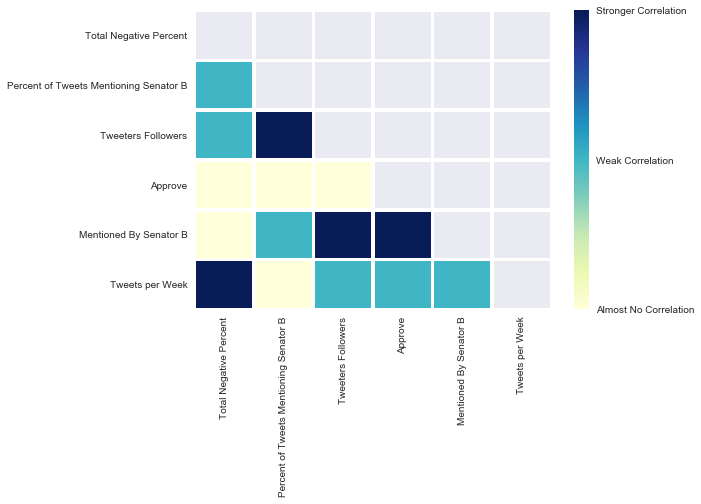

In [175]:
mask = np.zeros_like(df_corr_JustMe)
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(df_corr_JustMe, cmap="YlGnBu", vmax=2, vmin=0, mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
ax.collections[0].colorbar.set_ticks([0, 1, 2])
ax.collections[0].colorbar.set_ticklabels(['Almost No Correlation', 'Weak Correlation','Stronger Correlation'])
plt.show()

In [ ]:
# From Above we can see that approval ratings and followers correlates more strongly with being mentioned by others than
# the general volatility of a given senators' tweets. Lets further investigate this effect by looking at the followers and 
# approval ratings of other senators.

In [209]:
df_forchord = pd.DataFrame([])
for screen_name in Legislators_twitter_id[0:81]:
    df_forchord = df_forchord.append(pd.DataFrame(get_all_tweets_References(screen_name)))
df_forchord.columns = ['Tweeter','Sentiment', 'Reference']
df_forchord = df_forchord.loc[df_forchord['Tweeter'] != df_forchord['Reference']]
df_forchord = df_forchord.merge(df_final[['Tweeter','Approve', 'Tweeters Followers']], how='left', left_on='Tweeter', right_on='Tweeter').drop(['Tweeter'], axis=1).fillna(value=0)
df_final_reference = df_final[['Tweeter','Approve', 'Tweeters Followers']].rename(columns={'Tweeter': 'Reference', 'Approve': 'Reference Approve', 'Tweeters Followers': 'Reference Followers'})
df_forchord = df_forchord.merge(df_final_reference, how='left', left_on='Reference', right_on='Reference').drop(['Reference'], axis=1).fillna(value=0)
df_forchord_positive = df_forchord.loc[df_forchord['Sentiment'] == 'positive']
df_forchord_positive = df_forchord_positive.drop(['Sentiment'], axis=1)
df_forchord_positive_followers = df_forchord_positive[['Tweeters Followers','Reference Followers']]
df_forchord_positive_approval = df_forchord_positive[['Approve','Reference Approve']]
df_forchord_negative = df_forchord.loc[df_forchord['Sentiment'] == 'negative']
df_forchord_negative = df_forchord_negative.drop(['Sentiment'], axis=1)
df_forchord_negative_followers = df_forchord_negative[['Tweeters Followers','Reference Followers']]
df_forchord_negative_approval = df_forchord_negative[['Approve','Reference Approve']]
df_forchord_neutral = df_forchord.loc[df_forchord['Sentiment'] == 'neutral']
df_forchord_neutral = df_forchord_neutral.drop(['Sentiment'], axis=1)
df_forchord_neutral_followers = df_forchord_negative[['Tweeters Followers','Reference Followers']]
df_forchord_neutral_approval = df_forchord_negative[['Approve','Reference Approve']]
df_forchord = df_forchord.drop(['Sentiment'], axis=1)
df_forchord_followers = df_forchord[['Tweeters Followers','Reference Followers']]
df_forchord_approval = df_forchord[['Approve','Reference Approve']]
df_forchord_positive_followers = pd.DataFrame(df_forchord_positive_followers.pivot_table(index='Tweeters Followers', columns='Reference Followers', aggfunc=len, fill_value=0).to_records())
df_forchord_positive_approval = pd.DataFrame(df_forchord_positive_approval.pivot_table(index='Approve', columns='Reference Approve', aggfunc=len, fill_value=0).to_records())
df_forchord_negative_followers = pd.DataFrame(df_forchord_negative_followers.pivot_table(index='Tweeters Followers', columns='Reference Followers', aggfunc=len, fill_value=0).to_records())
df_forchord_negative_approval = pd.DataFrame(df_forchord_negative_approval.pivot_table(index='Approve', columns='Reference Approve', aggfunc=len, fill_value=0).to_records())
df_forchord_neutral_followers = pd.DataFrame(df_forchord_neutral_followers.pivot_table(index='Tweeters Followers', columns='Reference Followers', aggfunc=len, fill_value=0).to_records())
df_forchord_neutral_approval = pd.DataFrame(df_forchord_neutral_approval.pivot_table(index='Approve', columns='Reference Approve', aggfunc=len, fill_value=0).to_records())
df_forchord_followers = pd.DataFrame(df_forchord_followers.pivot_table(index='Tweeters Followers', columns='Reference Followers', aggfunc=len, fill_value=0).to_records())
df_forchord_approval = pd.DataFrame(df_forchord_approval.pivot_table(index='Approve', columns='Reference Approve', aggfunc=len, fill_value=0).to_records())
df_forchord_approval

,Approve,33,37,39,40,41,42,43,44,45,...,52,53,54,55,56,60,61,62,63,67
0,33,0,0,0,1,0,0,0,0,6,...,1,2,0,0,0,0,0,1,0,0
1,37,0,0,1,0,0,0,0,0,5,...,0,0,2,0,2,0,0,0,0,0
2,38,0,0,0,0,0,3,0,0,2,...,0,5,0,3,0,0,0,0,1,0
3,39,1,1,0,1,0,0,3,2,1,...,3,2,0,4,1,0,0,1,0,0
4,40,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,41,0,0,1,0,1,0,0,0,2,...,0,5,2,3,0,1,0,1,0,0
6,42,0,0,7,0,2,0,2,1,2,...,1,3,2,2,2,1,2,0,0,0
7,43,0,0,0,0,1,1,0,0,0,...,0,1,0,0,6,0,3,2,0,0
8,44,0,0,2,1,0,0,0,1,3,...,2,1,0,0,1,0,0,0,0,0
9,45,12,5,3,2,2,0,1,2,6,...,0,6,0,3,10,1,1,8,0,0


In [201]:
#df_final[['Tweeter','Approve', 'Tweeters Followers']]
df_forchord_temp = df_forchord.merge(df_final[['Tweeter','Approve', 'Tweeters Followers']], how='left', left_on='Tweeter', right_on='Tweeter').drop(['Tweeter'], axis=1).fillna(value=0)
df_final_reference = df_final[['Tweeter','Approve', 'Tweeters Followers']].rename(columns={'Tweeter': 'Reference', 'Approve': 'Reference Approve', 'Tweeters Followers': 'Reference Followers'})
df_forchord_temp = df_forchord_temp.merge(df_final_reference, how='left', left_on='Reference', right_on='Reference').drop(['Reference'], axis=1).fillna(value=0)
df_forchord_temp

,Sentiment,Approve,Tweeters Followers,Reference Approve,Reference Followers
0,positive,45,70266.0,48,292924.0
1,positive,45,70266.0,48,292924.0
2,neutral,45,70266.0,48,292924.0
3,positive,45,70266.0,48,292924.0
4,positive,45,70266.0,49,48828.0
5,positive,45,70266.0,51,16221.0
6,neutral,45,70266.0,51,16221.0
7,neutral,45,70266.0,51,16221.0
8,neutral,45,70266.0,51,16221.0
9,positive,45,70266.0,51,16221.0


In [197]:
df_corr_noSentiment = df_final.drop(['Total Negative Percent',
                                     'Total Neutral Percent', 
                                     'Total Positive Percent',
                                     'Negatively Mentioned Senator B Approval',
                                     'Neutrally Mentioned Senator B Approval',
                                     'Positively Mentioned Senator B Approval',
                                     'Negatively Mentioned Senator B Followers',
                                     'Neutrally Mentioned Senator B Followers',
                                     'Positively Mentioned Senator B Followers',
                                     'Tweeters Followers',
                                     'Approve',
                                     'Dissaprove',
                                     'Dont Know',
                                     'Approval Rating of Senator B Who Negatively Mentions Senator A',
                                     'Approval Rating of Senator B Who Neutrally Mentions Senator A',
                                     'Approval Rating of Senator B who Positively Mentions Senator A',
                                     'Followers of Senator B Who Negatively Mentions Sentor A',
                                     'Followers of Senator B Who Neutrally Mentions Senator A',
                                     'Followers of Senator B Who Positively Mentions Senator A',
                                     'Tweets per Week'
                                    ]
                                    , axis=1).fillna(value=0).corr(method='pearson')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in df_corr_noSentiment.columns if df_corr_noSentiment[c].dtype in numerics]:
    df_corr_noSentiment[c] = df_corr_noSentiment[c].abs()
for r in [r for r in df_corr_noSentiment.columns if df_corr_noSentiment[r].dtype in numerics]:
    df_corr_noSentiment[r] = pd.qcut(df_corr_noSentiment[r], 3, labels=False)
df_corr_noSentiment

,Average Approval for All Mentioned Senator Bs,Average Followers for All Mentioned Senator Bs,Percent of Tweets Mentioning Senator B,"Average, Overall Approval Rating of Senator B Who Mentions Senator A","Average, Overall Followers of Senator B Who Mentions Senator A",Mentioned By Senator B
Average Approval for All Mentioned Senator Bs,2,2,0,0,0,0
Average Followers for All Mentioned Senator Bs,2,2,2,1,1,1
Percent of Tweets Mentioning Senator B,0,0,2,0,0,0
"Average, Overall Approval Rating of Senator B Who Mentions Senator A",0,1,1,2,2,2
"Average, Overall Followers of Senator B Who Mentions Senator A",1,0,0,1,2,1
Mentioned By Senator B,1,1,1,2,1,2


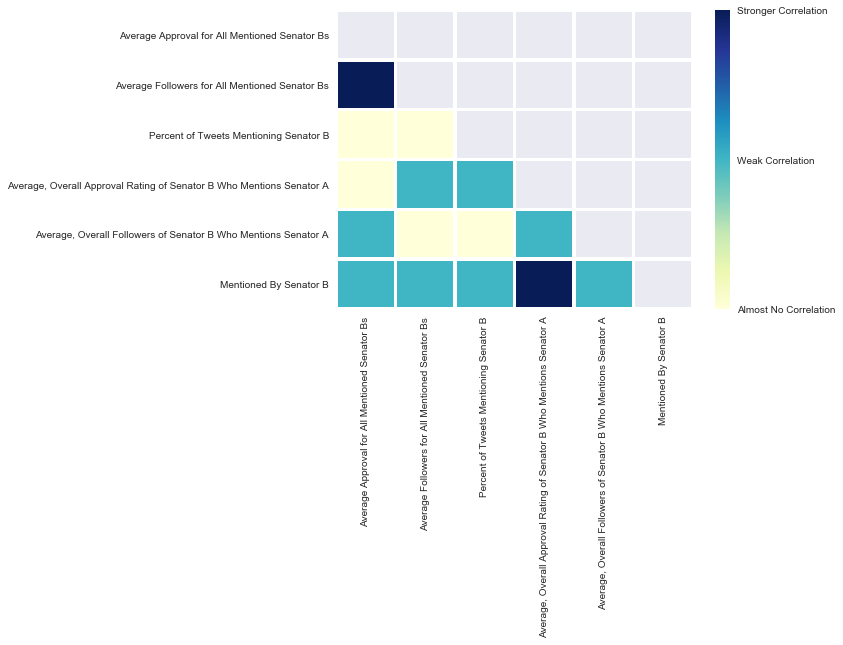

In [165]:
mask = np.zeros_like(df_corr_noSentiment)
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(df_corr_noSentiment, cmap="YlGnBu", vmax=2, vmin=0, mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
ax.collections[0].colorbar.set_ticks([0, 1, 2])
ax.collections[0].colorbar.set_ticklabels(['Almost No Correlation', 'Weak Correlation','Stronger Correlation'])
plt.show()

In [144]:
# Approval Ratings Appear to have little to do with the volatility (nagativity or positivity) of a given Senators tweets. 
# However, this does appear to be a relationship between Followers, Mentions of each other, Approvals ratings of those mentioned 
# and the volatility of tweets toward other senators.
# We investigate further by slicing into the negative and positive correlations
list(df_corr_noSentiment)

['Total Negative Percent',
 'Total Neutral Percent',
 'Total Positive Percent',
 'Average Approval for All Mentioned Senator Bs',
 'Average Followers for All Mentioned Senator Bs',
 'Percent of Tweets Mentioning Senator B',
 'Tweeters Followers',
 'Approve',
 'Average, Overall Approval Rating of Senator B Who Mentions Senator A',
 'Average, Overall Followers of Senator B Who Mentions Senator A',
 'Mentioned By Senator B',
 'Tweets per Week']

In [176]:
df_corr_Sentiment = df_final.drop(['Total Negative Percent',
                                   'Total Neutral Percent',
                                   'Total Positive Percent',
                                   'Average Approval for All Mentioned Senator Bs',
                                   'Average Followers for All Mentioned Senator Bs',
                                   # 'Negatively Mentioned Senator B Approval',
                                   'Neutrally Mentioned Senator B Approval',
                                   # 'Positively Mentioned Senator B Approval',
                                   # 'Negatively Mentioned Senator B Followers',
                                   'Neutrally Mentioned Senator B Followers',
                                   # 'Positively Mentioned Senator B Followers',
                                   'Percent of Tweets Mentioning Senator B',
                                   'Tweeters Followers',
                                   'Approve',
                                   'Dissaprove',
                                   'Dont Know',
                                   # 'Approval Rating of Senator B Who Negatively Mentions Senator A',
                                   'Approval Rating of Senator B Who Neutrally Mentions Senator A',
                                   # 'Approval Rating of Senator B who Positively Mentions Senator A',
                                   # 'Followers of Senator B Who Negatively Mentions Sentor A',
                                   'Followers of Senator B Who Neutrally Mentions Senator A',
                                   # 'Followers of Senator B Who Positively Mentions Senator A',
                                   'Average, Overall Approval Rating of Senator B Who Mentions Senator A',
                                   'Average, Overall Followers of Senator B Who Mentions Senator A',
                                   'Mentioned By Senator B',
                                   'Tweets per Week'
                                    ]
                                    , axis=1).fillna(value=0).corr(method='pearson')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in df_corr_Sentiment.columns if df_corr_Sentiment[c].dtype in numerics]:
    df_corr_Sentiment[c] = df_corr_Sentiment[c].abs()
for r in [r for r in df_corr_Sentiment.columns if df_corr_Sentiment[r].dtype in numerics]:
    df_corr_Sentiment[r] = pd.qcut(df_corr_Sentiment[r], 3, labels=False)
df_corr_Sentiment

,Negatively Mentioned Senator B Approval,Positively Mentioned Senator B Approval,Negatively Mentioned Senator B Followers,Positively Mentioned Senator B Followers,Approval Rating of Senator B Who Negatively Mentions Senator A,Approval Rating of Senator B who Positively Mentions Senator A,Followers of Senator B Who Negatively Mentions Sentor A,Followers of Senator B Who Positively Mentions Senator A
Negatively Mentioned Senator B Approval,2,2,2,1,0,0,1,0
Positively Mentioned Senator B Approval,2,2,1,0,0,0,0,0
Negatively Mentioned Senator B Followers,2,2,2,0,1,1,0,0
Positively Mentioned Senator B Followers,1,0,0,2,0,1,0,1
Approval Rating of Senator B Who Negatively Mentions Senator A,0,1,1,1,2,2,2,1
Approval Rating of Senator B who Positively Mentions Senator A,0,0,2,2,2,2,1,2
Followers of Senator B Who Negatively Mentions Sentor A,1,0,0,0,2,0,2,2
Followers of Senator B Who Positively Mentions Senator A,0,1,0,2,1,2,2,2


In [177]:
len(list(df_corr))

17

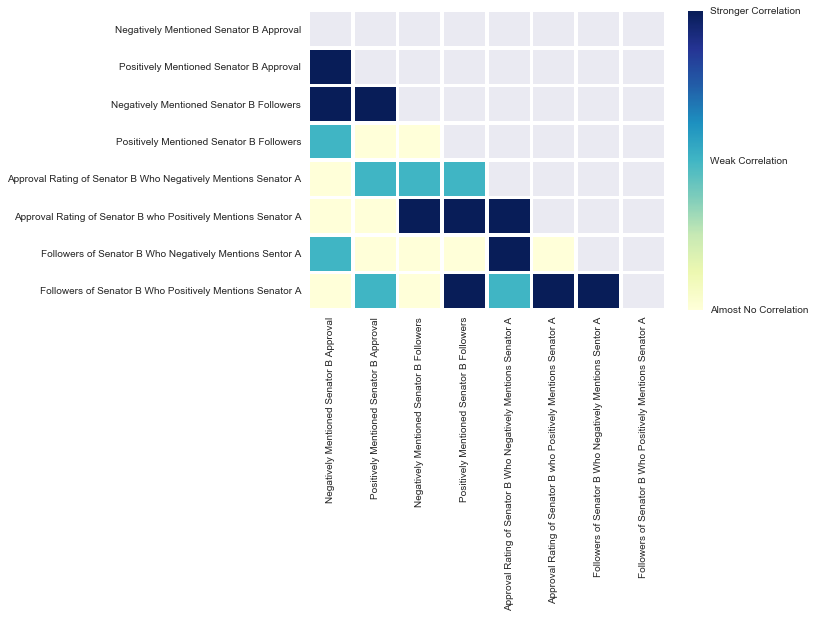

In [178]:
mask = np.zeros_like(df_corr_Sentiment)
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(df_corr_Sentiment, cmap="YlGnBu", vmax=2, vmin=0, mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
ax.collections[0].colorbar.set_ticks([0, 1, 2])
ax.collections[0].colorbar.set_ticklabels(['Almost No Correlation', 'Weak Correlation','Stronger Correlation'])
plt.show()

In [ ]:
# There does appear to be something of a subtle frenemies effect; Sentiment of tweets toward each other appears to have some 
# correlation with the approval ratings and followers count of a senator. For further investigation we will see if the volitility
# of a tweet toward other senators can predict the followers or approval ratings in the network.

In [45]:
data = [
    go.Parcoords(
        line = dict(color = df_final['Approve'],
                    colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = min(df_final['Approve']),
                   cmax = max(df_final['Approve'])),
        dimensions = list([
            dict(range = [min(df_final['Tweeters Followers']),max(df_final['Tweeters Followers'])],
                label = 'Tweeters Followers', values = df_final['Tweeters Followers']),
            dict(range = [min(df_final['Negative Mentionees Followers']),max(df_final['Negative Mentionees Followers'])],
                label = 'Negative Mentionees Followers', values = df_final['Negative Mentionees Followers']),
            dict(range = [min(df_final['Neutral Mentionees Followers']),max(df_final['Neutral Mentionees Followers'])],
                label = 'Neutral Mentionees Followers', values = df_final['Neutral Mentionees Followers']),
            dict(range = [min(df_final['Positive Mentionees Followers']),max(df_final['Positive Mentionees Followers'])],
                label = 'Positive Mentionees Followers', values = df_final['Positive Mentionees Followers']),
            dict(range = [min(df_final["('Mentioners Followers', 'negative')"]),max(df_final["('Mentioners Followers', 'negative')"])],
                label = "('Mentioners Followers', 'negative')", values = df_final["('Mentioners Followers', 'negative')"])
        ])
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'parcoords-basic')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pllemke/0 or inside your plot.ly account where it is named 'parcoords-basic'
